# Chapter 13: A Line-by-Line Implementation of Attention and Transformer


Transformers are deep neural networks that can efficiently solve sequence-to-sequence prediction tasks. Compared to their predecessors such as recurrent neural networks (RNNs) or convolutional neural networks (CNNs), transformers are excellent at capturing long-term dependencies among elements in the input and output sequences. Further, unlike recurrent models, transformers can be trained in parallel and this has greatly reduced the amount of training time and made training on huge datasets possible. The transformer architecture is evolutionary, and it leads to the recent rise of large language models (LLMs) such as ChatGPT, BERT, and T5. The transformer architecture is the very foundation of the recent AI boom that’s ushered in by the release of ChatGPT.

Before the transformer architecture was invented in 2017 by a group of Google researchers, natural language processing (NLP) and other sequence-to-sequence prediction tasks were handled mainly by RNNs such as long short term memory (LSTM) algorithms. However, RNNs process inputs sequentially, this means the model uses information on previous elements in a sequence to predict the next element. The fact that RNNs conduct computation along the symbol positions of the input and output sequences prevents parallel training, which makes training slow and impossible to train the models on huge datasets. Further, when recurrent models process a sequence, it gradually forgets the earlier elements in the sequence, which makes these models unsuccessful in capturing long-term dependencies in sequences.

The key innovation of the transformer architecture is the attention mechanism, which assigns weights on how a word is related to other word in the sequence. The higher the weight, the more closely the two words are related. These weights are learned from large sets of training data in the training process. Therefore, a trained LLM such as ChatGPT is able to figure out the relationship between any two words in a sentence, hence making sense of the human language. Further, since the inputs are not handled sequentially in the model, transformers can be trained in parallel and this greatly reduces the training time. More importantly, parallel training makes it possible to train transformers on large amounts of data and this makes LLMs extremely intelligent and knowledgeable. This leads to the rise of LLMs such as ChatGPT and the current AI boom. 

In this chapter, we'll try to create a transformer from scratch by following the steps in the 2017 paper to translate English to French. Along the way, you'll understand how the self-attention mechanism works in a transformer; what the query, key, and value vectors are and how to use them to calculate scaled dot product attention (SDPA). You'll create an encoder layer by adding a normalization layer and a feed-forward layer to a multi-head attention layer. You'll then stack six encoder layers to form the encoder in the transformer. You'll similarly create a decoder in the transformer and learn to output the French translation by decoding the output from the encoder in an autoregressive fashion. 

Once the model is created, you'll use a dataset of more than 47,000 English to French translations to train the model. The trained model can accurately translate English sentences to French that match the translation qualities of Google Translate. 

Start a new cell in ch13.ipynb and execute the following lines of code in it:

In [1]:
import os

os.makedirs("files/ch13", exist_ok=True)

# 1	Introduction to Transformers and Attention
In this section, you'll learn what is a transformer and how the attention mechanism works. 
## 1.1	What is attention?
The attention mechanism is an algorithm to calculate the relationships between any two elements in a sequence. It assigns scores to show how an element in a sequence is related to all other elements. The higher the score, the more closely related the two elements are. In NLP, for example, the attention mechanism allows the model to relate a word to other words in a sentence in a meaningful way.  

Let's walk through an example in the context of the original 2017 paper "Attention is all you need," by a group of Google researchers. The authors invented the transformer architecture with an attention-based mechanism to solve machine language translation problems (for example, English to French translation). Figure 13.1 below is a diagram of the transformer architecture. The left side is the encoder and the right side is the decoder. 

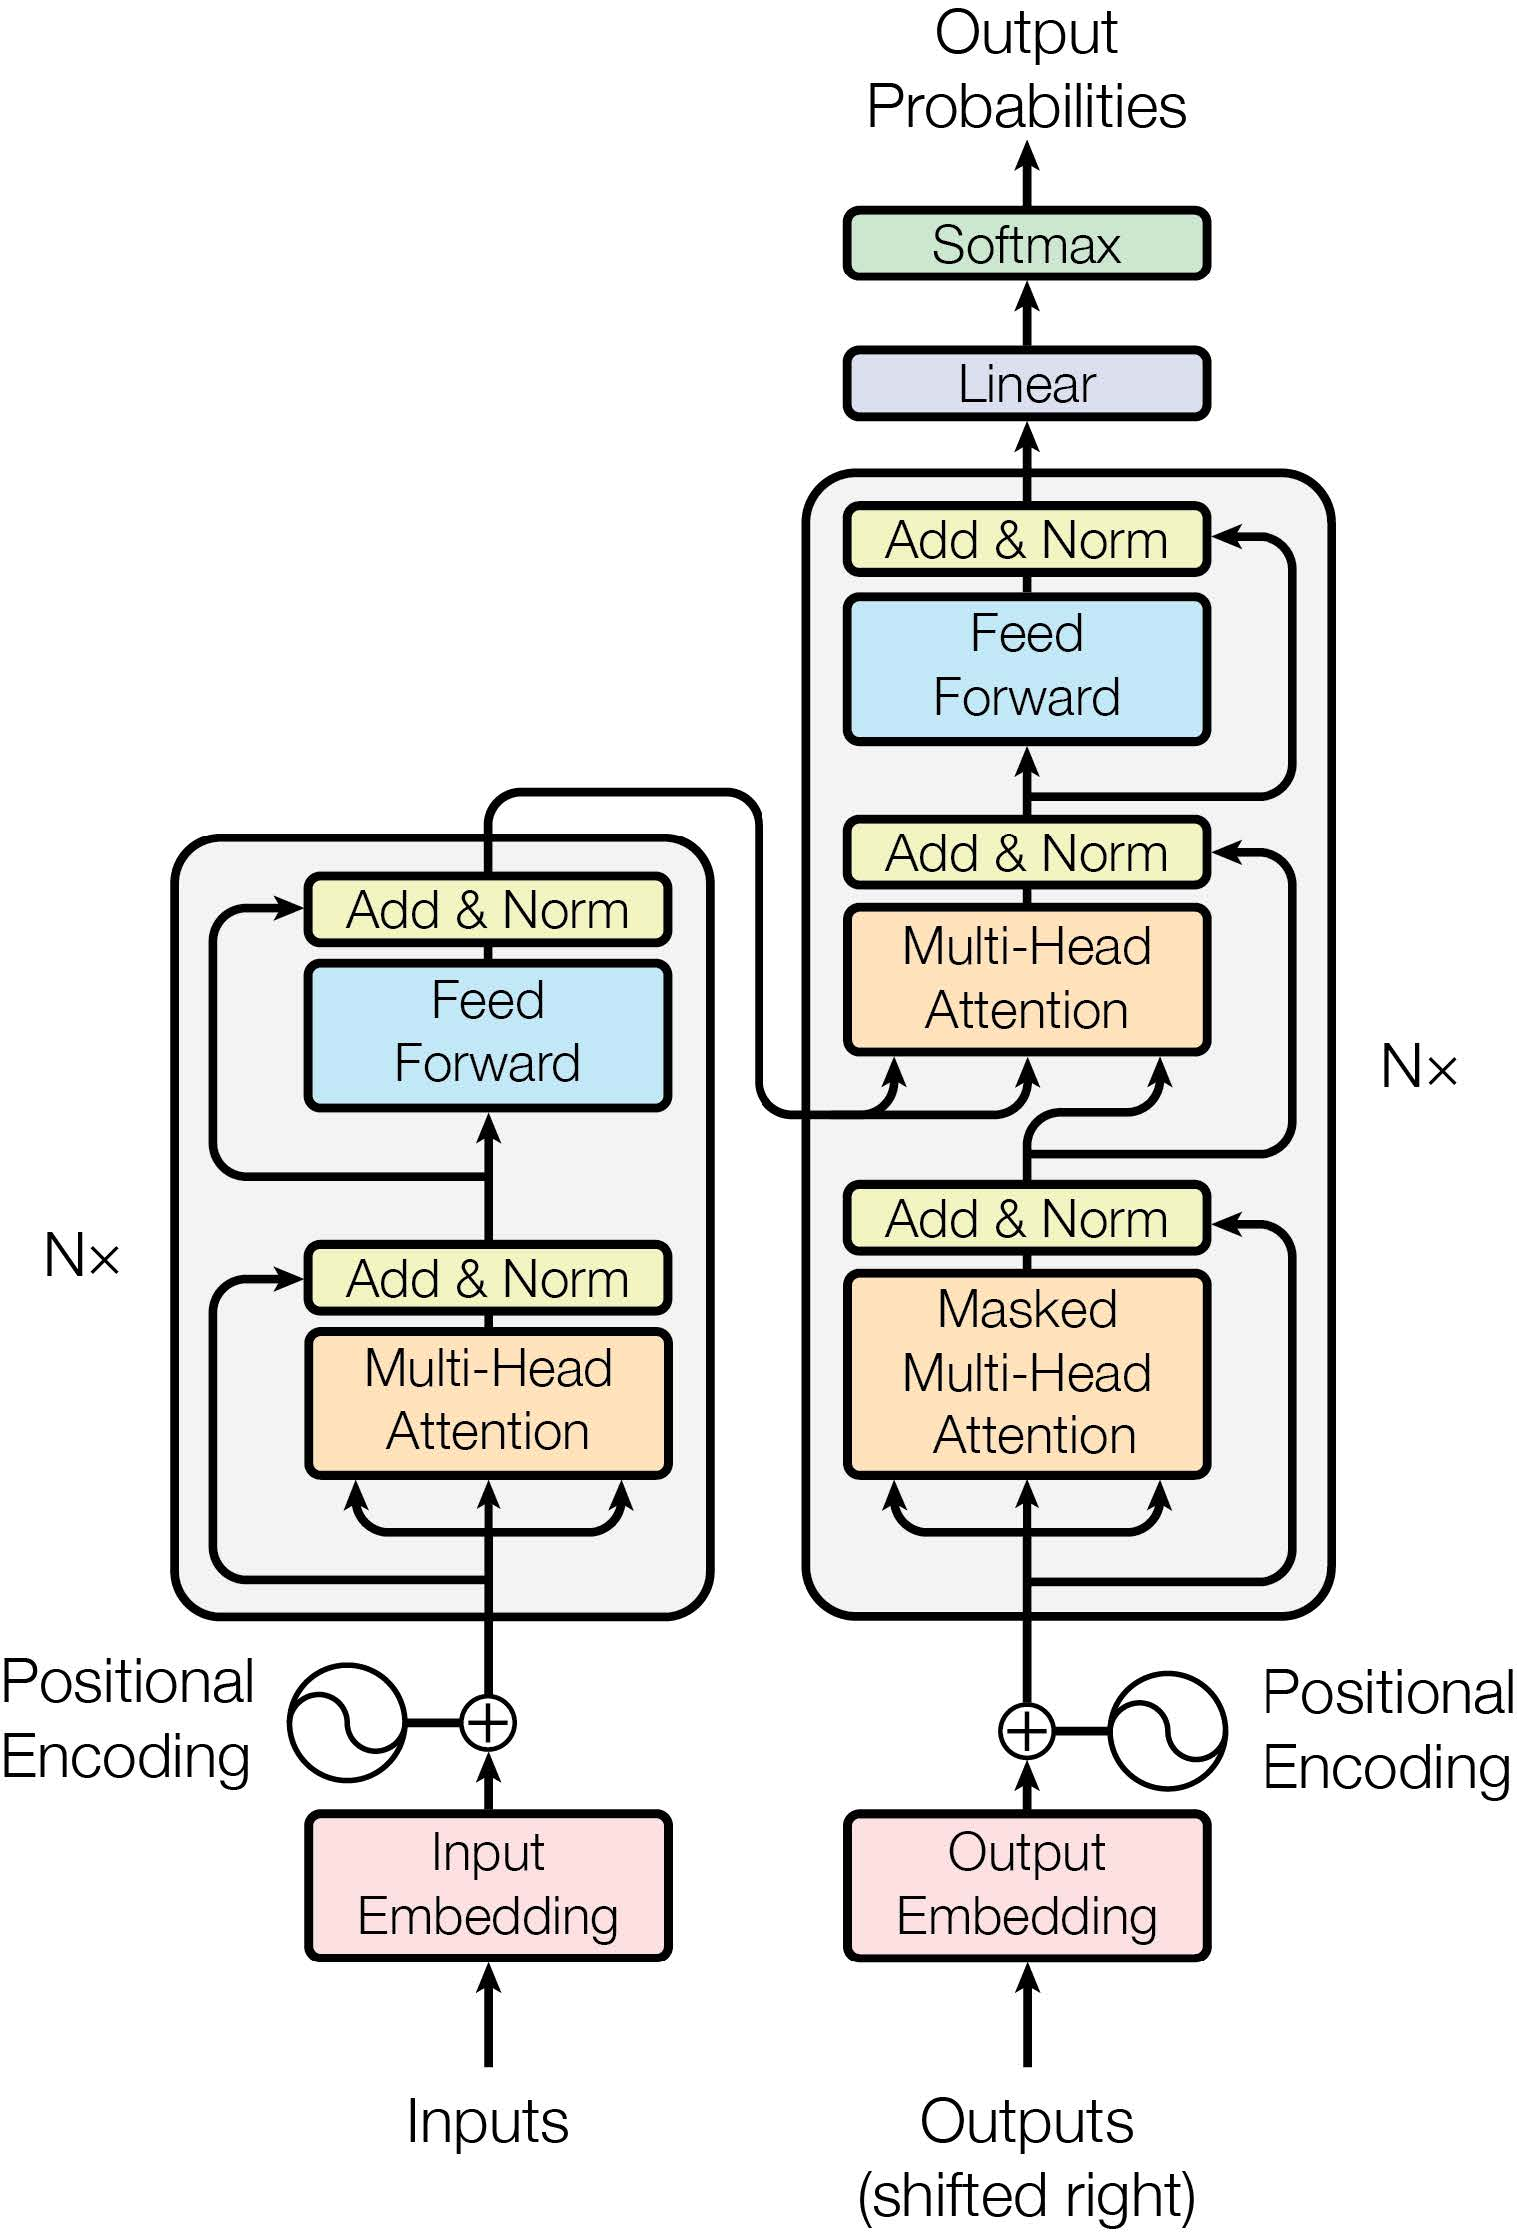
Figure 13.1. The Transformer Architecture (Source: Attention Is All You Need, Vaswani et al 2017)

The encoder in the transformer converts an English phrase such as "I don't speak French" into a continuous vector representation that holds the meaning of the original phrase. The decoder in the transformer then takes the vector representation and converts it to the French translation "Je ne parle pas francais". The encoder's job is to extract the meaning of the original English phrase. For example, if the encoder successfully does its job, the phrases "I don't speak French" and "I do not speak French" should be converted to identical (or close to identical) vector representations. This way, the decoder will look at the vector representation and come up with the same translation. As an aside, if you use Google Translate, the two phrases do lead to identical French translations.

Here is how the encoder in the transformer tackles the problem. First, the model converts a sentence into tokens. Tokens are words or parts of words that act as semantic units in a language. For example, "I do not speak French" has five tokens: (I, do, not, speak, french). On the other hand, "I don't speak French" has a set of five slightly different tokens: (I, don, 't, speak, french). 

Since machine learning models cannot process text directly, we need to convert text into numbers before feeding them to the models. The obvious solution is the one-hot variables. For example, there are 11055 distinct tokens in the translation example we'll encounter later in this chapter. If we use one-hot variables, each token is represented by a vector with a length of 11055 with 1 in one position and 0 in all others. The 
sentence "I don't speak French" is represented by a matrix of 5 by 11055, where 5 is the number of tokens in the sentence and 11055 is the dimension of each token represented by a one-hot vector. However, using a vector with a dimension of 11055 to represent a token is inefficient: there are too many parameters in the model and this reduces the training speed. Instead, the first job of the encoder is to convert one-hot variables to word embedding: the encoder in the transformer uses a continuous vector of length, say, 256, to represent the 11055 tokens. After word embedding, the 
sentence "I don't speak French" is represented by a matrix of 5 by 256. 

The encoder also uses the positional encoding (a technique
for determining the relative or absolute position of elements within a sequence) to capture the ordering of words in the input sequence. Specifically, the positional encoding layer uses the following sine and cosine functions:
$$PE_{(pos,2i)}=sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos,2i+1)}=cos(pos/10000^{2i/d_{model}})$$
The encoder in the transformer calculates a vector using the sine function for even indexes and another vector using the cosine function for odd indexes. The positional encoding is then added to the sequence’s word embeddings before we feed the sum to the attention layers. For the example sentence "I don't speak French," the encoder generates a word embedding and a positional embedding, each with a dimension of 5 by 256. The encoder adds the two embeddings together to obtain one single matrix with a dimension of 5 by 256 before feeding the sum to attention layers. The encoder then uses the attention mechanism to gradually convert the inputs into a fixed-length abstract vector representation before passing it to the decoder. 

While there are different ways to calculate attention, we’ll use the most common method, the scaled dot product attention (SDPA). This mechanism is also called self-attention due to the fact that the algorithm calculates how a word attends to all other words in the sequence, including the word itself. Specifically, the attention weights are calculated by first projecting the inputs into three vectors, query Q, key K, and value V. The values in these three vectors are learned during the training process from data. 

The method of using query, key, and value to calculate attention comes from retrieval systems. For example, you may go to a public library to search for a book. You can type in, say, "machine learning in finance," in the library's search engine. In this case, the query is "machine learning in finance." The keys are the book titles, book descriptions, and so on. The library's retrieval system will recommend a list of books (values) for you based on the similarities between the query and the keys. Naturally, books with phrases "machine learning" or "finance" or both in titles or descriptions come up on top while books with neither phrase in the title or description will not show up because these books will be assigned a low matching score. 

Similarly, in the attention mechanism, we look at the similarities between the projected query and key vectors. The scaled dot product attention calculates the do product of the query and key vectors. If the two vectors are similar to each other, the dot product is high and vice versa. Now, let's go back to the example of the sentence "I don't speak French," which is represented by a matrix of, say, X, with a dimension of 5 by 256. We'll project X into three vectors to obtain query Q, key K, and value V, each has a dimension of 5 by 256. We then calculate the attention score as follows: 
$$AttentionScore(Q,K)=\frac{Q* K_{transpose}}{\sqrt{d_k}}$$
where $d_k$ is the dimension of the key, and in our example, $d_k=256$. We scale the dot product of query and key by the dimension of the key to stabilize training.

The attention score shows how each token in the sentence is related to other tokens, based on the context of the sentence. In our case, the attention score is a 5 by 5 matrix, showing how each word in the sentence is related to other words. 

To give you a feeling on how the attention scores can capture the meaning of a word in a sentence based on the context, let’s use the word “bank” as an example. The word bank is most related to the word “fishing” in the sentence "I went fishing at the river bank yesterday." Because the river bank is where the action “fishing” takes place. See the graph below, and you’ll learn this very example in Chapter 2 on how to calculate the attention weights based on pretrained GPT2-XL model. 


<img src="https://gattonweb.uky.edu/faculty/lium/gai/BankMoney.png">
Figure 13.2. How the word bank is related to fishing
On the other hand, in the sentence "Kate deposited a check in the bank,” the word bank is most closely related to the word check  and the trained model understands that the bank in this case is a financial institution. 
<img src="https://gattonweb.uky.edu/faculty/lium/gai/RiverBank.png">
Figure 13.3. How the word bank is related to a check

We then apply the softmax function on the attention scores so that the total attention of a word with respect to all other words in the sentence adds up to 100%, and multiply the attention weights by the value vector V, like so:
The attention is calculated by using the formula:
$$Attention(Q,K,V)=softmax(\frac{Q* K_{transpose}}{\sqrt{d_k}})* V$$
which also has a dimension of 5 by 256. 

Further, instead of using one set of query, key, and value vectors, the transformer model uses a concept called multi-head attention. The 256-dimensional query, key, and value vectors are split into 8 heads, and each head has a set of query, key, and value vectors with dimensions of 32 (because 256/8=32). Each head pays attention to different parts or aspects of the input, enabling the model to capture a broader range of information and form a more detailed and contextual understanding of the input data. Multi-head attention is especially useful when a word has multiple meanings in a context, such as in a pun. Let's continue the "bank" example we mentioned earlier. Consider the pun joke, "Why is the river so rich? Because it has two banks." The word bank has two meanings in this sentence: on the one hand, it means the land along the riverside. On the other hand, it means a financial institution since the question is why the river is so rich. Anyone who owns two banks should be rich! 

To summarize, the self attention mechanism converts the word and positional embedding matrix X for the phrase "I don't speak French", with a dimension of 5 by 256, into a new representation, also with a dimension of 5 by 256, based on the semantic meanings of the words in the sentence. After the inputs go through several stacks of attention layers, along with other operations (such as residual connections, layer normalizations, and the feed forward network that we'll explain in the next section), the encoder finally comes up with vector representations of the phrases "I don't speak French". The vector representation captures the semantic meanings of the phrase. As a result, the encoder generates close to identical vector representations for the phrases "I do not speak French" and "I don't speak French" since the two phrases have the same semantic meanings. 

Now that you understand how the attention mechanism works, let's discuss the architecture of transformers. 

## 1.2	The transformer architecture

As we mentioned in the last subsection, the original transformer architecture consists of an encoder and a decoder as shown in Figure 13.1. In the example of English to French translation, the encoder converts an English phrase into a continuous vector representation that holds the meaning of the phrase. The decoder constructs the target language sentence (i.e., the French translation for the English phrase) by predicting one word at a time in an autoregressive manner, based on the previous words and the encoder’s continuous vector representation of the original English phrase. 


The encoder in the transformer consists of N identical encoder layers. Each encoder layer two sub-layers. The first is a multi-head self-attention layer, while the second is a basic, position-wise, fully connected feed-forward network. The model then employs a residual connection (meaning the input to the attention layer is added to the output of the attention layer), followed by a normalization layer, as shown on the left side of Figure 13.1. The normalization layer normalizes each of the inputs in a batch independently across all features so that they all have zero mean and unit standard deviation. This helps stabilize training.   


The decoder in the transformer consists of N identical decoder layers. Each decoder layer consists of a multi-head self-attention layer and a basic, position-wise, fully connected feed-forward network with residual connections, as shown in the right side of the figure above. In addition to the above two sublayers, each decoder layer also has a third sub-layer that applies multi-head attention over the encoder stack’s output. Furthermore, the decoder stack’s self-attention sub-layer is masked to prevent positions from attending to subsequent positions. The mask forces the model to use previous elements in a sequence to predict later elements. To start with, the decoder takes the French phrase as inputs: the decoder converts the French tokens in the phrase into word embedding and positional embedding and add the two embeddings before feeding the sum to the decoder layers. 

The decoder is autoregressive and generates the output word by word in the following sense. In the first time step, the decoder takes the start token as the only input (the start and end tokens signify the start and end of a sentence, and most models use <sos> to <eos> as start and end tokens, respectively). The decoder then looks at the vector representation of the English phrase "I don't speak French," and predicts what's the token after <sos>. If the decoder chooses "Je" as the output in the first timestep, the decoder then use "<sos> Je" as the input in the second timestep to predict the next word, and so on. When the predicted next word is <eos>, which signals the end of the sentence, the decoder knows that the translation job is done and stops decoding. 


There are three types of transformers: encoder-only transformers, decoder-only transformers, and encoder-decoder transformers. The English French translation transformer we discussed above is an example of encoder-decoder transformers. Encoder-decoder transformers are needed for handling complicated tasks such as multi-modal models such as text to image tasks or speech recognition tasks. 
    
  
An encoder only transformer consists of N identical encoder layers. An encoder only transformer is capable of converting a sequence into abstract continuous vector representations. For example, BERT is an encoder only transformer that contains 12 encoder layers. An encoder only transformer can be used for text classification, for example. If two stentences have similar vector representations, we can classify the two sentences into one category. On ther other hand, if two sequences have very different vector representations by the encoder, we can put them in different categories. 

A decoder only transformer also consists of N identical blocks, and each block is a decoder block as shown on the right side of Figure 13.1. For example, GPT2-XL is a decoder only transformer that contains 48 decoder layers. The decoder only transformer can generate text based on a prompt, for example. It extracts the semantic meaning of the words in the prompt and predicts the most likely next word. It then adds the word to the end of the prompt and repeats the process until the text reaches a certain length. 

# 2. Word Embedding and Positional Encoding
To make the explanation of self-attention and transformers more relatable, we'll use the English to French translation as our example. By working through the example of training a model to translate English phrases to French, you'll have a deep understanding of various components of a transformer and how the attention mechanism works. 

Imagine that you have collected 47,000 pairs of English to French translations. Your goal is to create a machine learning model and train the model by using the data set. 

## 2.1. Word Tokenization
First go to https://gattonweb.uky.edu/faculty/lium/gai/en2fr.zip to download zip file that contains the 47,000 English to French translations that I collected from various sources. Unzip the file and place en2fr.csv in the folder /Desktop/gai/files/ch13/ on your computer. We'll load the data and take a look as follows:

In [2]:
import pandas as pd

df=pd.read_csv("files/ch13/en2fr.csv")
print(df.iloc[222])

Unnamed: 0                                                    0
en            Two skiers are making their way through woodland.
fr                 Deux skieurs font leur chemin dans la forêt.
Name: 222, dtype: object


We randomly selected an example. The English phrase says "Two skiers are making their way through woodland." The corresponding French translation is "Deux skieurs font leur chemin dans la forêt."

Next, we'll tokenize both the English and the French phrases in the dataset. We'll use XLM model from Hugging Face as the tokenizer. The model can tokenize both English and French phrases. 

In [3]:
from transformers import XLMTokenizer

tokenizer = XLMTokenizer.from_pretrained("xlm-clm-enfr-1024")

tokenized_en=tokenizer.tokenize("I don't speak French.")
print(tokenized_en)
tokenized_fr=tokenizer.tokenize(
    "Deux skieurs font leur chemin dans la forêt.")
print(tokenized_fr)

['i</w>', 'don</w>', "'t</w>", 'speak</w>', 'fr', 'ench</w>', '.</w>']
['deux</w>', 'skieurs</w>', 'font</w>', 'leur</w>', 'chemin</w>', 'dans</w>', 'la</w>', 'fore', 't</w>', '.</w>']


In the above code cell, the model tokenizes the English phrase "I don't speak French." into different tokens. Tokens are semantic units in natural language processing and they are words or a part of a word. The tokens for "I don't speak French." are ['i', 'don', "'t", 'speak', 'fr', 'ench', '.']. Note the model uses '</w>' to separate different tokens unless two tokens are a pair. 

Machine learning models cannot process text directly, hence we need to convert text into numerical representations before feeding them to the models. For that purpose, we create a dictionary to map all English tokens to integers:

In [4]:
# build dictionaries
from collections import Counter

en=df["en"].tolist()
fr=df["fr"].tolist()
en_tokens=[["BOS"]+tokenizer.tokenize(x)+["EOS"] for x in en]        
fr_tokens=[["BOS"]+tokenizer.tokenize(x)+["EOS"] for x in fr] 

# apply to English 
word_count=Counter()
for sentence in en_tokens:
    for word in sentence:
        word_count[word]+=1
frequency=word_count.most_common(50000)        
total_en_words=len(frequency)+2
en_word_dict={w[0]:idx+2 for idx,w in enumerate(frequency)}
en_word_dict["PAD"]=0
en_word_dict["UNK"]=1
# another dictionary to map numbers to tokens
en_idx_dict={v:k for k,v in en_word_dict.items()}

We add the tokens "BOS" and "EOS" to the beginning and end of each phrase. The dictionary *en_word_dict* maps each token to an integer. The padding token "PAD" is assigned a value of 0 and the unknown token "UNK" is assigned an integer of 1. We also create a dictionary *en_idx_dict* to map integers to tokens. This way, we can convert a sequence of indexes back to a sequence of tokens so we know what the original English phrase is.

For example, we can now convert the English phrase "I don't speak French." into numerical representations as follows by using the dictionary *en_word_dict* as follows:

In [5]:
enidx=[en_word_dict[i] for i in tokenized_en]   
print(enidx)

[15, 100, 38, 377, 476, 574, 5]


We can also convert the above numerical representations back to tokens by using the dictionary *en_word_dict* as follows:

In [6]:
entokens=[en_idx_dict[i] for i in enidx]   
print(entokens)
en_phrase="".join(entokens)
en_phrase=en_phrase.replace("</w>"," ")
print(en_phrase)

['i</w>', 'don</w>', "'t</w>", 'speak</w>', 'fr', 'ench</w>', '.</w>']
i don 't speak french . 


The dictionary *en_word_dict* converts the numbers back to the tokens we have seen before. We then further convert the tokens back to the English phrase by replacing '</w>' with an empty space. 

We can apply the same rule to French phrases:

In [7]:
# do the same for French phrases
word_count=Counter()
for sentence in fr_tokens:
    for word in sentence:
        word_count[word]+=1
frequency=word_count.most_common(50000)        
total_fr_words=len(frequency)+2
fr_word_dict={w[0]:idx+2 for idx,w in enumerate(frequency)}
fr_word_dict["PAD"]=0
fr_word_dict["UNK"]=1
fr_idx_dict={v:k for k,v in fr_word_dict.items()}

The dictionary *fr_word_dict* maps each French token to an integer and the dictionary *en_idx_dict* maps integers back to French tokens. Below, we convert the phrase "Deux skieurs font leur chemin dans la forêt." to numerical representations:

In [8]:
fridx=[fr_word_dict[i] for i in tokenized_fr]   
print(fridx)

[25, 2643, 682, 234, 750, 14, 13, 651, 438, 4]


The following code cell converts the above numerical representations back to French tokens and restores the original French phrase:

In [9]:
frtokens=[fr_idx_dict[i] for i in fridx]   
print(frtokens)
fr_phrase="".join(frtokens)
fr_phrase=fr_phrase.replace("</w>"," ")
print(fr_phrase)

['deux</w>', 'skieurs</w>', 'font</w>', 'leur</w>', 'chemin</w>', 'dans</w>', 'la</w>', 'fore', 't</w>', '.</w>']
deux skieurs font leur chemin dans la foret . 


Note that the restoration of the English and French phrases is not perfect since the tokenization process converts all capital letters to lower case letters and removes certain symbols.

## 2.2. Sequence Padding
The numerical representations that we feed to the transformer must have the same length. However, the English and French phrases have various lengths. To overcome this, we add 0s at the end of numerical representations of shorter phrases so all inputs to the transformer model have the same length. 

First, we convert all English phrases to their numerical representations and do the same for French phrases: 

In [10]:
out_en_ids=[[en_word_dict.get(w,1) for w in s] for s in en_tokens]
out_fr_ids=[[fr_word_dict.get(w,1) for w in s] for s in fr_tokens]
sorted_ids=sorted(range(len(out_en_ids)),
                  key=lambda x:len(out_en_ids[x]))
out_en_ids=[out_en_ids[x] for x in sorted_ids]
out_fr_ids=[out_fr_ids[x] for x in sorted_ids]

Next, we put the numerical representations into batches for training. 

In [11]:
import numpy as np

batch_size=128
idx_list=np.arange(0,len(en_tokens),batch_size)
np.random.shuffle(idx_list)

batch_indexs=[]
for idx in idx_list:
    batch_indexs.append(np.arange(idx,min(len(en_tokens),
                                          idx+batch_size)))

To pad sequences, we define the following function:

In [12]:
def seq_padding(X, padding=0):
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))])
        if len(x) < ML else x for x in X
    ])

The function first finds out the longest sequence in the batch and adds 0s at the end of other sequences so that all sequences in the batch have the same length. 

To save space, we define a *Batch* class in the local module *ch13util*. Download the file *ch13util.py* from the book's GitHub repository and save in the folder /Desktop/gai/utils/ on your computer. Open the file and familiarize yourself with the content in the file. The *Batch* class is defined as follows in the local module:

In [13]:
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import numpy as np
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape),
                              k=1).astype('uint8')
    output = torch.from_numpy(subsequent_mask) == 0
    return output

from torch.autograd import Variable
def make_std_mask(tgt, pad):
    tgt_mask = (tgt != pad).unsqueeze(-2)
    output = tgt_mask & Variable(
        subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return output 

# define the Batch class
class Batch:
    def __init__(self, src, trg=None, pad=0):
        src = torch.from_numpy(src).to(DEVICE).long()
        trg = torch.from_numpy(trg).to(DEVICE).long()
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

The *Batch* class creates a mask for the source sequence. The mask tells the model to pay attention to the original sequence only, not to the padded 0s at the end (which are used just to make sure all sequences have the same length). The class also creates a standard mask for the target sequence. The standard mask also hides future tokens in the target sequence and this forces the model to predict future tokens based on previous tokens. 

In [14]:
from utils.ch13util import Batch

batches=[]
for b in batch_indexs:
    batch_en=[out_en_ids[x] for x in b]
    batch_fr=[out_fr_ids[x] for x in b]
    batch_en=seq_padding(batch_en)
    batch_fr=seq_padding(batch_fr)
    batches.append(Batch(batch_en,batch_fr))

The list *batches* contains data batches for training. Each batch has 128 pairs of numerical representations of English and French phrases, respectively. 

## 2.3. Word Embedding
The number of indexes in numerical representations of the English and French phrases is too large. We can find out how many distinct indexes we need for each language by counting the number of elements in the dictionaries *en_word_dict* and *fr_word_dict*:

In [15]:
src_vocab = len(en_word_dict)
tgt_vocab = len(fr_word_dict)
print(f"there are {src_vocab} distinct English tokens")
print(f"there are {tgt_vocab} distinct French tokens")

there are 11055 distinct English tokens
there are 11239 distinct French tokens


There are 11,055 distinct English tokens and 11,239 distinct French tokens in our data set. If we use one-hot variables, there are too many parameters to train. Instead, we'll use word embedding to use a continuous vector of length, say, *d_model=256*, to represent the each phrase. The *Embeddings* class is defined in the local module *ch13util* as follows:

In [16]:
import math

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        out = self.lut(x) * math.sqrt(self.d_model)
        return out

## 2.4. Positional Encoding
To model the order of elements in the input and output sequences, we'll first create positional encodings of the sequences as follows:

In [17]:
import torch
from torch import nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model, device=DEVICE)
        position = torch.arange(0., max_len, 
                                device=DEVICE).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0., d_model, 2, device=DEVICE)
            * -(math.log(10000.0) / d_model))
        pe_pos = torch.mul(position, div_term)
        pe[:, 0::2] = torch.sin(pe_pos)
        pe[:, 1::2] = torch.cos(pe_pos)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)  

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)],
                         requires_grad=False)
        out = self.dropout(x)
        return out

The purpose of positional encoding is to determine the relative or absolute position of elements in a sequence). Specifically, the positional encoding class we defined above uses the following sine and cosine functions, based on the position *pos* and the dimension *i*:
$$PE_{(pos,2i)}=sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos,2i+1)}=cos(pos/10000^{2i/d_{model}})$$
The class *PositionalEncoding* calculates a vector using the sine function for even indexes and another vector using the cosine function for odd indexes. Each dimension has a different wave frequency and offset. 

In the cell below, we plot the wave pattern of different dimensions:

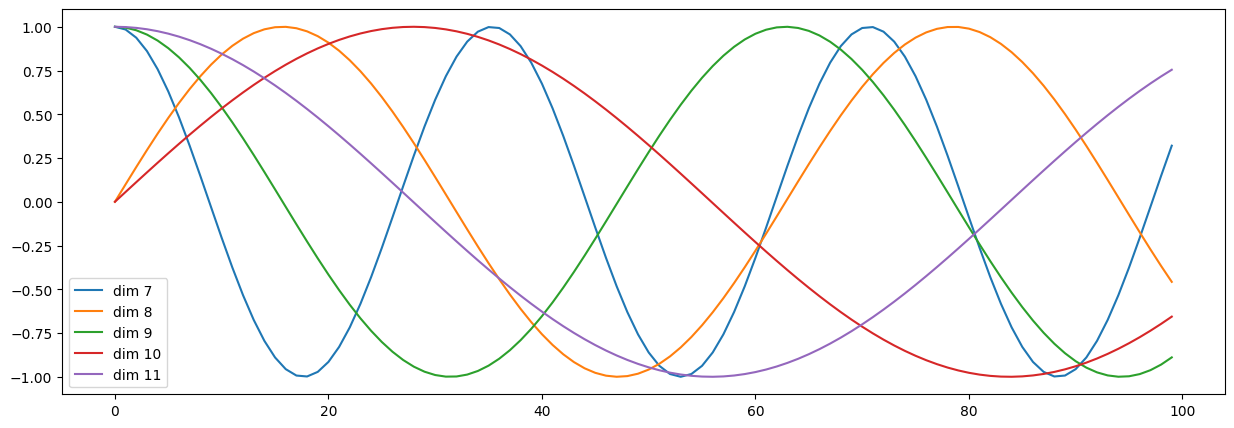

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(32, 0)
x = Variable(torch.zeros(1, 100, 32)).to(DEVICE)
y = pe.forward(x)
plt.plot(np.arange(100), y[0, :, 7:12].data.cpu().numpy())
plt.legend(["dim %d"%p for p in [7,8,9,10,11]])

# 3 Create A Transformer
We'll follow the 2017 paper and create and train an encoder-decoder transformer to translate English to French. The code is adapted from the Chinese to English translator by Chris Cui (https://cuicaihao.com/the-annotated-transformer-english-to-chinese-translator/) and the German to English translator by Alexander Rush (http://nlp.seas.harvard.edu/annotated-transformer/).  

## 3.1	The Transformer
To create an encoder-decoder transformer, we define a Transformer class in the local module *ch13util.py* as follows:

In [19]:
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from torch import nn
# An encoder-decoder transformer
class Transformer(nn.Module):
    def __init__(self, encoder, decoder,
                 src_embed, tgt_embed, generator):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), 
                            memory, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask, tgt_mask):
        memory = self.encode(src, src_mask)
        output = self.decode(memory, src_mask, tgt, tgt_mask)
        return output

The transformer consists of an encoder and a decoder. The encoder converts the numerical representation of an English phrase such as "How are you?" into a continuous vector representation (which we call *memory* in the above *Transformer* class). The decoder then takes the output from the encoder and generates the translation in an autoregressive fashion: it generates one element at a time, based on the previously generated elements and the output from the encoder (more on this later). 

The encoder consists of N=6 identical encoder layers. The *Encoder* class is defined as follows in the local module: 

In [20]:
# Create an encoder
from copy import deepcopy
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = nn.ModuleList(
            [deepcopy(layer) for i in range(N)])
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
            output = self.norm(x)
        return output

The encoder consists of N identical encoder layers. We employ a residual connection here: the input to the encoder layer is added to the output of the encoder layer. After that, we apply a normalization layer to the sum. The normalization layer normalizes each of the inputs in a batch independently across all features so that they all have zero mean and unit standard deviation. This helps stabilize training. Specifically, we define the *EncoderLayer* class and the *LayerNorm* class in the local module as follows:

In [21]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = nn.ModuleList([deepcopy(
        SublayerConnection(size, dropout)) for i in range(2)])
        self.size = size  

    def forward(self, x, mask):
        x = self.sublayer[0](
            x, lambda x: self.self_attn(x, x, x, mask))
        output = self.sublayer[1](x, self.feed_forward)
        return output 
    
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        output = x + self.dropout(sublayer(self.norm(x)))
        return output  

class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True) 
        std = x.std(-1, keepdim=True)
        x_zscore = (x - mean) / torch.sqrt(std ** 2 + self.eps)
        output = self.a_2*x_zscore+self.b_2
        return output

The decoder in the transformer consists of N identical decoder layers. Each decoder layer consists of a multi-head self-attention layer and a basic, position-wise, fully connected feed-forward network with residual connections, as shown in the right side of the figure above. In addition to the above two sublayers, each decoder layer also has a third sub-layer that applies multi-head attention over the encoder stack’s output. Furthermore, the decoder stack’s self-attention sub-layer is masked to prevent positions from attending to subsequent positions. The mask forces the model to use previous elements in a sequence to predict later elements. To start with, the decoder takes the French phrase as inputs: the decoder converts the French tokens in the phrase into word embedding and positional embedding and add the two embeddings before feeding the sum to the decoder layers.

Specifically, the *Decoder* class is defined in the local module as follows:

In [22]:
# Create a decoder
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = nn.ModuleList(
            [deepcopy(layer) for i in range(N)])
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        output = self.norm(x)
        return output

Similar to what we did with the encoder layers, we apply residual connection and layer normalization in each decoder layer. The decoder layer is defined as follows: 

In [23]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn,
                 feed_forward, dropout):
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = nn.ModuleList([deepcopy(
        SublayerConnection(size, dropout)) for i in range(3)])

    def forward(self, x, memory, src_mask, tgt_mask):
        x = self.sublayer[0](x, lambda x: 
                 self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x:
                 self.src_attn(x, memory, memory, src_mask))
        output = self.sublayer[2](x, self.feed_forward)
        return output 

## 3.2. The Attention Mechanism
While there are different attention mechanisms, we'll use the scaled dot product attention (SDPA). The SDPA attention mechanism uses query, key, and value to calculate the relationships among elements in a sequence. It assigns scores to show how an element in a sequence is related to all other elements. Specifically, we calculate the attention score as follows: 
$$AttentionScore(Q,K)=\frac{Q* K_{transpose}}{\sqrt{d_k}}$$
where $d_k$ is the dimension of the key. 

See Figure 13.4 for an illustration of how the attention score is calculated.


<img src="https://gattonweb.uky.edu/faculty/lium/gai/attn.jpg">

Figure 13.4. The scaled dot product attention mechanism (Source: Attention Is All You Need, Vaswani et al 2017)

The *attention()* function is defined in the local module as follows:

In [24]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, 
              key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = nn.functional.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

Instead of using one set of query, key, and value vectors, the transformer model uses a concept called multi-head attention. Our 256-dimensional query, key, and value vectors are split into 8 heads, and each head has a set of query, key, and value vectors with dimensions of 32 (because 256/8=32). Each head pays attention to different parts or aspects of the input, enabling the model to capture a broader range of information and form a more detailed and contextual understanding of the input data.

<img src="https://gattonweb.uky.edu/faculty/lium/gai/multihead.jpg">

Figure 13.5 Multi-head attention (Source: Attention Is All You Need, Vaswani et al 2017)

The *MultiHeadedAttention* class is defined in the local module as follows:

In [25]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = nn.ModuleList([deepcopy(
            nn.Linear(d_model, d_model)) for i in range(4)])
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)  
        query, key, value = [l(x).view(nbatches, -1, self.h,
           self.d_k).transpose(1, 2)
         for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(
            nbatches, -1, self.h * self.d_k)
        output = self.linears[-1](x)
        return output 

## 3.3.	Position-Wise Feed Forward Networks
Each encoder layer and decoder layer also contains a feed forward sublayer. However, unlike regular fully connected dense layers, the neural network processes each embedding independently. It doesn't treat the sequence of embeddings as a single vector. Therefore, we often call it a position-wide feed forward network (or a 1-D convolutional network). 

We define a *PositionwiseFeedForward* class in the local module as follows:

In [26]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h1 = self.w_1(x)
        h2 = self.dropout(h1)
        return self.w_2(h2)   

## 3.4. Put All Pieces Together
Finally, we define a *Generator* class in the local module to generate the most likely next token. The class is defined as follows:

In [27]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        out = self.proj(x)
        probs = nn.functional.log_softmax(out, dim=-1)
        return probs   

The output of the *Generator* class are probabilities for all the indexes corresponding to the tokens in the target language. This allows the model to predict one token at a time in an autoregressive fashion, based on previously generated tokens and the output from the encoder. 

Now we are ready to put all pieces together and create our Transformer model. The *create_model()* function defined in the local module accomplishes that:

In [28]:
# create the model
def create_model(src_vocab, tgt_vocab, N, d_model,
                 d_ff, h, dropout=0.1):
    attn=MultiHeadedAttention(h, d_model).to(DEVICE)
    ff=PositionwiseFeedForward(d_model, d_ff, dropout).to(DEVICE)
    pos=PositionalEncoding(d_model, dropout).to(DEVICE)
    model = Transformer(
        Encoder(EncoderLayer(d_model,deepcopy(attn),deepcopy(ff),
                             dropout).to(DEVICE),N).to(DEVICE),
        Decoder(DecoderLayer(d_model,deepcopy(attn),
             deepcopy(attn),deepcopy(ff), dropout).to(DEVICE),
                N).to(DEVICE),
        nn.Sequential(Embeddings(d_model, src_vocab).to(DEVICE),
                      deepcopy(pos)),
        nn.Sequential(Embeddings(d_model, tgt_vocab).to(DEVICE),
                      deepcopy(pos)),
        Generator(d_model, tgt_vocab)).to(DEVICE)
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model.to(DEVICE)

Finally, we import the *create_model()* function from the local module and construct a transformer so that we can use it to train the English to French translator:

In [29]:
from utils.ch13util import create_model

model = create_model(src_vocab, tgt_vocab, N=6,
    d_model=256, d_ff=1024, h=8, dropout=0.1)

The original 2017 paper by Vaswani et al uses various combinations of hyperparameters when constructing the model. Here we choose a model dimension of 256 with 8 heads. 

# 4. Train the Transformer

We'll train the transformer we created in the last section by using the batches of English to French translations that we prepared earlier in this chapter. 

## 4.1 Loss Function and Optimizer
The original 2017 paper by Vaswani et al uses label smoothing during training. Label smoothing is a technique used to address overconfidence problems (the predicted probability is greater than the true probability) in classifications. 

We define the following class in the local module:

In [30]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super().__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')  
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, 
               target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        output = self.criterion(x, Variable(true_dist,
                            requires_grad=False))
        return output

The optimizer we use is the Adam optimizer with $\beta_1=0.9$, $\beta_2=0.98$, and $\epsilon=10^{-9}$. We define the *NoamOpt* class in the local module to change the learning rate during the training process:

In [31]:
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        if step is None:
            step = self._step
        output = self.factor * (self.model_size ** (-0.5) *
        min(step ** (-0.5), step * self.warmup ** (-1.5)))
        return output

We create the optimizer for training as follows:

In [32]:
from utils.ch13util import NoamOpt

optimizer = NoamOpt(D_MODEL, 1, 2000, torch.optim.Adam(
    model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

To create the loss function for training, we first define the following class in the local module:

In [33]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm.float()

We then define the loss function as follows:

In [34]:
from utils.ch13util import (LabelSmoothing,
       SimpleLossCompute)

criterion = LabelSmoothing(tgt_vocab, 
                           padding_idx=0, smoothing=0.0)
loss_func = SimpleLossCompute(
            model.generator, criterion, optimizer)

Next, we'll train the transformer by using the data we prepared earlier in the Chapter. 

## 4.2 The Training Process
We'll train the model for 100 epochs. We'll calculate the loss and the number of tokens from each batch. After each epoch, we calculate the average loss in the epoch as the ratio between the total loss and the total number of tokens:

In [35]:
# train for 100 epochs
for epoch in range(100):
    model.train()
    tloss=0
    tokens=0
    for batch in batches:
        out = model(batch.src, batch.trg, 
                    batch.src_mask, batch.trg_mask)
        loss = loss_func(out, batch.trg_y, batch.ntokens)
        tloss += loss
        tokens += batch.ntokens
    print(f"Epoch {epoch}, average loss: {tloss/tokens}")
torch.save(model.state_dict(),"files/ch13/en2fr.pth")   

...
Epoch 95, average loss: 0.11190220713615417 
Epoch 96, average loss: 0.10964725911617279 
Epoch 97, average loss: 0.10869214683771133 
Epoch 98, average loss: 0.10700632631778717 
Epoch 99, average loss: 0.1059982031583786



The above training process takes about an hour if you are using a GPU. It may take several hours if you are using CPU training. Once the training is done, the model weights are saved as *en2fr.pth* on your computer. 

# 5. Translate English to French with the Trained Model
Now that you have trained the transformer, you can use it to translate any English sentence to French. We define a function *en2fr()* as follows: 

In [36]:
def en2fr(eng):
    # tokenize the English sentence
    tokenized_en=tokenizer.tokenize(eng)
    # add beginning and end tokens
    tokenized_en=["BOS"]+tokenized_en+["EOS"]
    # convert tokens to indexes
    enidx=[en_word_dict[i] for i in tokenized_en]  
    src=torch.tensor(enidx).long().to(DEVICE).unsqueeze(0)
    # create mask to hide padding
    src_mask=(src!=0).unsqueeze(-2)
    # encode the English sentence
    memory=model.encode(src,src_mask)
    # start translation in an autogressive fashion
    start_symbol=fr_word_dict["BOS"]
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(100):
        out = model.decode(memory,src_mask,Variable(ys),
        Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, torch.ones(1, 1).type_as(
            src.data).fill_(next_word)], dim=1)
    # convert French indexes to French tokens
    translation=[]
    for j in range(1,100):
        sym = fr_idx_dict[ys[0, j].item()]
        if sym != 'EOS':
            translation.append(sym)
        else:
            break
    # convert tokens to sentences
    trans="".join(translation)
    trans=trans.replace("</w>"," ") 
    print(trans)
    return trans

I added explanations as comments in the above code cell. First, we use the tokenizer to convert the English sentence to tokens. We then add in the beginning token "BOS" and the end token "EOS". We use the dictionary *en_word_dict* we created earlier in the chapter to convert tokens to indexes. We also create a mask for the input indexes before feeding them to the encoder in the trained model. The encoder produces an abstract vector representation so the decoder understands the meaning of the English sentence.  

Based on the abstract vector representation of the English sentence produced by the encoder, the decoder in the trained model starts translation in an autoregressive manner, starting with the beginning token "BOS". In each time step, the decoder generates the most likely next token based on previously generated tokens, until the predicted token is "EOS", which signals the end of the sentence. 

Let's try the defined function on the English phrase "Today is a beautiful day!", like so:

In [37]:
eng = "Today is a beautiful day!"
translated_fr = en2fr(eng)

aujourd 'hui est une belle journee !


You can verify that the French translation indeed means "Today is a beautiful day!"

Next, we'll test if the trained model generates the same translation for the two English sentence "I don't speak French." and "I do not speak French." First, let's try the sentence "I don't speak French."

In [38]:
eng = "I don't speak French."
translated_fr = en2fr(eng)

je ne parle pas francais . 


Now let's try the sentence "I do not speak French."

In [39]:
eng = "I do not speak French."
translated_fr = en2fr(eng)

je ne parle pas francais . 


The results show identical translations for the two sentences. This means the encoder part of the transformer captures the semantic meaning of the two phrases, and encode them as identical (or close to identical) abstract continuous vector representations before passing them to the decoder.